<a href="https://colab.research.google.com/github/Rafaacv/learningPython/blob/master/cropdisease_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In-depth explanation.<br>
For a simpler explanation I'll see you in the presentation.

**IDENTIFYING CROP DISEASE IN POTATO PLANTS.**<br>
In this notebook, I'll cover the full process for the development of a model that can help identify diseases in the potato plant based on pictures of its leaves. <br>
The explanation will be around the model in the current notebook, and I'll compare with 3 others. It'll also cover some of the technical problems faced in working on this project. <br>
<br>
**WHY IDENTIFY CROP DISEASE IN POTATO PLANTS?**<br>
Some facts: <br>
According to the National Institute of Food and Agriculture, “between 20% to
40% of global crop production is lost to pests annually,” representing around 220 billion USD.<br>

In particular, with potato blight disease, according to the US Government Global Hunger and Food Security Initiative (https://www.canr.msu.edu/biotechpp/about-late-blight-disease) farmers around the world lose 6.7 billion annually, some of it goes to the direct loss of 12-30% of their potato crop, and the rest is gone in 20-30 funcigicide sprays that also affect the environment and human health.

With this model, I would like to facilitate the early detection of crop diseases, which could help farmers, particularly smaller ones, to prevent or contain broader infections.<br>

For the purpose of this model (more on this later) we'll focus on indentifying potato blight.<br>
<br>
**HYPOTHESIS**<br>
In summary, if my hypothesis is correct, this model works, and we deploy the model in an acessible way: something like an Android app that works on and offline, we could participate in helping medium to small farmers to identify blight from its early stages and possibly reduce its spread and the need to invest in fungicides, thus mitigating the impact in human health and the environment as a byproduct.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from scipy.ndimage import gaussian_filter
from tensorflow.keras.metrics import Precision, Recall


from skimage.transform import resize

# Paths
base_path = "/content/drive/MyDrive/cropdisease/data"
train_dir = os.path.join(base_path, 'train')

valid_dir = os.path.join(base_path, 'valid')

# Image parameters for input to our model
img_height, img_width = 150, 150


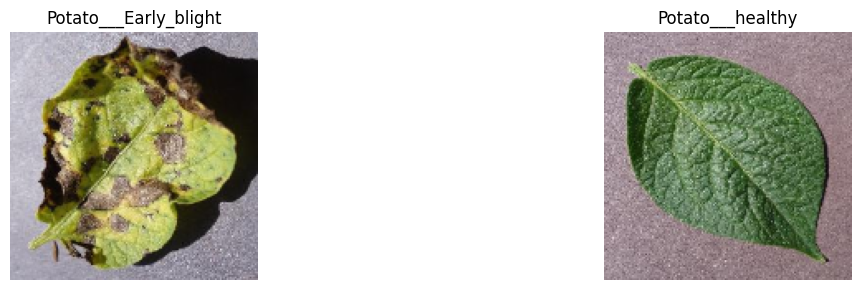

In [ ]:
def display_sample_images(directory):
    # Get only directories and ignore any files
    folders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    # Randomly select 5 folders
    selected_folders = np.random.choice(folders, 2, replace=False)

    fig, ax = plt.subplots(1, 2, figsize=(15, 3))

    for i, class_folder in enumerate(selected_folders):
        class_images = os.listdir(os.path.join(directory, class_folder))
        # Select one image from the current folder
        image_name = np.random.choice(class_images, 1)[0]

        image_path = os.path.join(directory, class_folder, image_name)
        img = plt.imread(image_path)
        ax[i].imshow(img)
        ax[i].set_title(class_folder)
        ax[i].axis('off')

        # Resize the image to 150x150 before displaying
        ax[i].imshow(resize(img, (150, 150)))

    plt.tight_layout()
    plt.show()

# Display the sample images
display_sample_images(train_dir)

**THE DATA**<br>
The original dataset contains 70297 images corresponding to 38 different labels (healthy crops and different diseases) for 14 different plants ([link to attempted model ](https://drive.google.com/file/d/1DkxopNoMSDXnYQc2CXI80m0rZWnE_v_t/view?usp=sharing)). <br>
HERE ARE SOME SAMPLES
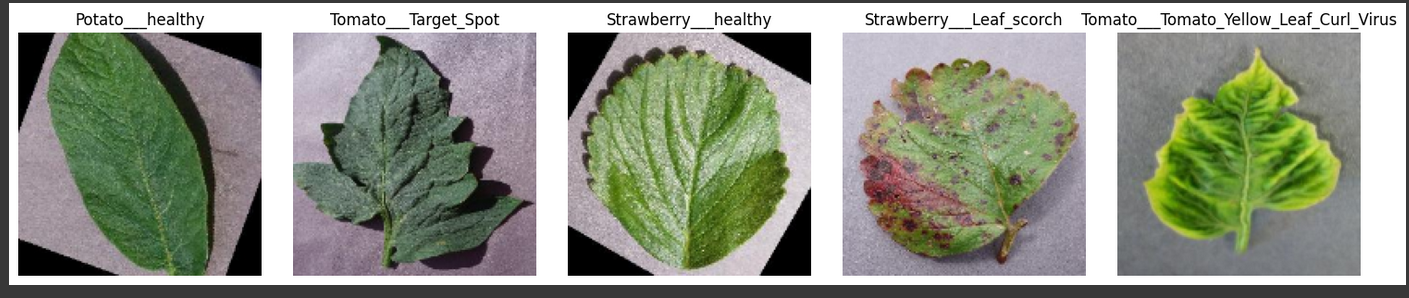

---


Because of computational restraints, I decided to reduce test my hypothesis only with potatoes since it's an internationally available crop, and it represented the least CPU demanding set in the data. Thus facilitating experimentation and validation.<br><br>
The data contains images of early blight, late blight, and healthy potato leaves. They are divided in 5702 images in the training set, 1426 pictures in the validation set, and 10 in the test set.<br>

[ORIGINAL DATASET](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data)

In [ ]:
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d)) and d != ".DS_Store"]

print('\n'.join(classes))



Potato___Early_blight
Potato___healthy
Potato___Late_blight


In [ ]:
print('Total classes '+ str(len(classes)))


Total classes 3


In [ ]:
diseases=[d for d in classes if 'healthy' not in d]
print('\n'.join(diseases))
print('Total diseases '+ str(len(diseases)))

Potato___Early_blight
Potato___Late_blight
Total diseases 2


In [ ]:
plants = list(set(d.split('___')[0] for d in classes))
print('\n'.join(plants))
print('Total plants '+ str(len(plants)))

Potato
Total plants 1


In [ ]:
# 1. Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=32, class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255.0
)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_height, img_width), batch_size=32, class_mode='categorical', shuffle=False)



Found 5702 images belonging to 3 classes.
Found 1426 images belonging to 3 classes.


**THE EXPERIMENT**<br><br>
The process consisted in creating and training 4 different models and see which one returned the best results.<br>
Model 1 to 3 are made on Tensorflow Keras, and Model 4 was created with Pytorch. You can take a look at the other models here:<br>


*   [Model 1](https://drive.google.com/file/d/1OaUFw-Fx2ZzYgtT3u-Jm8_Y9QbKP6XSR/view?usp=share_link): learning rate 0.001, patience 3, 20 epochs, 3 layers, l2 reg 0.001. It returned an 80% accuracy rate when tested against the Test Set, with 7 correct predictions and 2 wrong ones.

*   Model 2 (this model): 13 layers, learning rate 0.001, 10 epochs, 12 reg 0.001. It returned 80% accuracy when tested against the Test Set, with 8 correct predictions 2 wrong ones.

*   [Model 3](https://drive.google.com/file/d/1bkGYk5H0Q0iMcsj5twpfgJH2m94K1XVv/view?usp=share_link): 13 layers, 10 epochs, l2 reg 0.001. It returned a 70% accuracy rate when tested against the Test Set, resulting in 7 correct predictions and 3 incorrect ones.
*   [Model 4](https://https://drive.google.com/file/d/133_Qc_Tb4AzvH-lDCF9ABkIpt4P1Dfpz/view?usp=share_link): A much simpler model, it reportred a 95% accuracy rate in training, but returned a 60% accuracy rate when tested against the test set with 6 correct predictions and 4 incorrect ones. ( I won't go in depth with this one)
<br><br>
After training the models, they were tested against a test image set for accuracy.<br><br>

**TECHNICAL DETAILS**

Base Model and Structure:<br>
        Model 1 employs a pre-trained VGG16 model as its base, with a custom top consisting of GlobalAveragePooling2D and a dense output layer. <br>
        Model 2 and Model 3 are built from scratch with a similar architecture comprising multiple Conv2D, MaxPooling2D, Dropout, Flatten, and Dense layers. However, Model 3 has a lower dropout rate (0.3) compared to Model 2 (0.5).<br><br>
    Learning Rate and Optimizer:<br>
        Model 1 uses a fixed learning rate with the Adam optimizer and incorporates a ReduceLROnPlateau callback to adjust the learning rate during training based on validation loss.
        Model 2 uses a fixed learning rate of 0.001 with the Adam optimizer and does not adjust the learning rate during training.
        Model 3 starts with a lower initial learning rate of 0.0005, uses an Adam optimizer, and employs a LearningRateScheduler callback to decay the learning rate over epochs.<br><br>
        Callbacks and Performance Metrics:<br>
    	All three models use the EarlyStopping callback to monitor validation loss and stop training early if validation loss does not improve.
    	Model 2 and Model 3 define a custom F1ScoreCallback to compute and print the F1 score at the end of each epoch.
    	Model 3 additionally uses a LearningRateScheduler callback to adjust the learning rate during training, which is not used in Model 1 and Model 2.<br><br>

In summary, Model 1 leverages transfer learning from a pre-trained VGG16 model, while Model 2 and Model 3 are built from scratch with slight differences in dropout rate, learning rate scheduling, and the initial learning rate. Model 3 has the most sophisticated learning rate scheduling among the three models.




In [ ]:
l2_reg = 0.001

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),  # Dropout layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    tf.keras.layers.Dropout(0.5),  # Another Dropout layer
    tf.keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)
# 4. Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define a custom callback to calculate F1-score after each epoch
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        precision = logs["val_precision"]
        recall = logs["val_recall"]
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-5))
        print(f"\nval_f1_score: {f1_score:.4f}")

f1_callback = F1ScoreCallback()

# Train the model with early stopping and F1-score callback
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, f1_callback]
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.7538 - precision: 0.8341 - recall: 0.6726
val_f1_score: 0.7703
179/179 [==============================] - 1761s 10s/step - loss: 0.8551 - accuracy: 0.7538 - precision: 0.8341 - recall: 0.6726 - val_loss: 0.7176 - val_accuracy: 0.7707 - val_precision: 0.7875 - val_recall: 0.7539
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.9270 - precision: 0.9316 - recall: 0.9239
val_f1_score: 0.9338
179/179 [==============================] - 97s 542ms/step - loss: 0.3589 - accuracy: 0.9270 - precision: 0.9316 - recall: 0.9239 - val_loss: 0.3362 - val_accuracy: 0.9348 - val_precision: 0.9371 - val_recall: 0.9306
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.9425 - precision: 0.9458 - recall: 0.9395
val_f1_score: 0.8194
179/179 [==============================] - 100s 558ms/step - loss: 0.3151 - accuracy: 0.9425 - precision: 

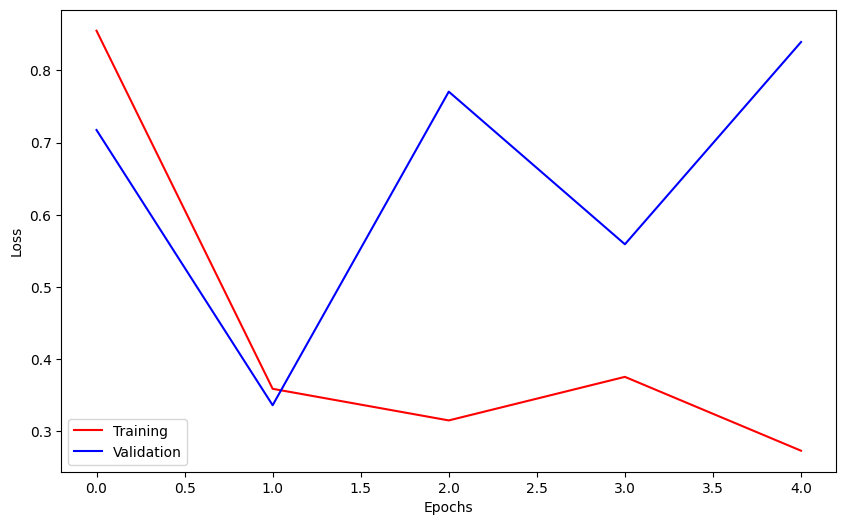

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

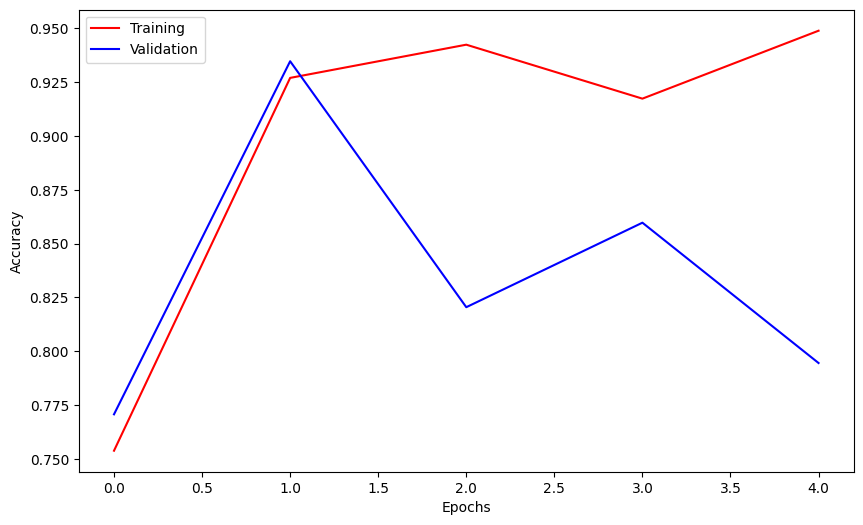

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

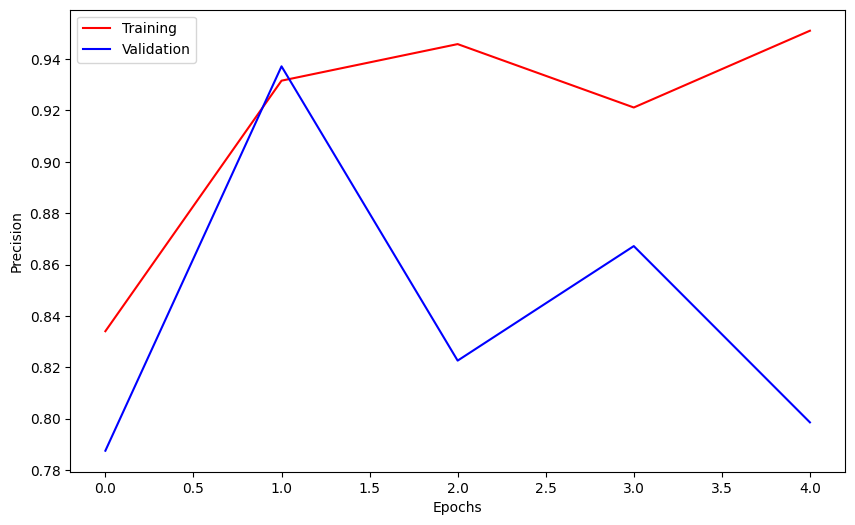

In [ ]:
prec = history.history['precision']
val_prec = history.history['val_precision']

epochs = range(len(prec))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,prec,c="red",label="Training")
plt.plot(epochs,val_prec,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

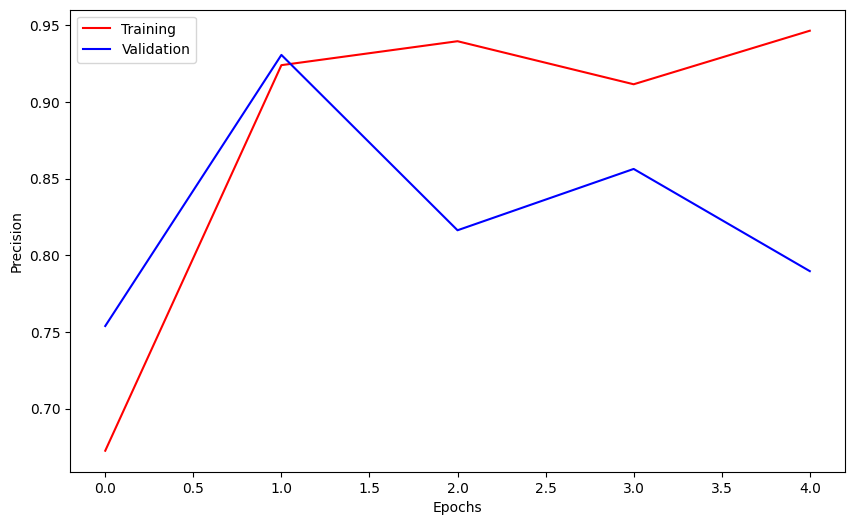

In [ ]:
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,rec,c="red",label="Training")
plt.plot(epochs,val_rec,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

In [ ]:
test_dir = "/content/drive/MyDrive/cropdisease/data/test"

test_datagen = ImageDataGenerator(
    rescale=1./255.0
)
# Using shuffle=False to ensure the order remains the same during predictions.
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode=None, shuffle=False)

# Predict
predictions = model.predict(test_generator)

predicted_classes = []
for pred in predictions:
    class_id = np.argmax(pred)
    class_label = list(train_generator.class_indices.keys())[class_id]
    predicted_classes.append((class_label, pred[class_id]))

# Print predictions
for i, (label, conf) in enumerate(predicted_classes):
    print(f"Image {i+1}: Predicted Class: {label}, Confidence: {conf:.2f}")


Found 10 images belonging to 3 classes.
1/1 [==============================] - 0s 212ms/step
Image 1: Predicted Class: Potato___Early_blight, Confidence: 1.00
Image 2: Predicted Class: Potato___Early_blight, Confidence: 1.00
Image 3: Predicted Class: Potato___healthy, Confidence: 0.91
Image 4: Predicted Class: Potato___Early_blight, Confidence: 1.00
Image 5: Predicted Class: Potato___Early_blight, Confidence: 0.96
Image 6: Predicted Class: Potato___Late_blight, Confidence: 0.99
Image 7: Predicted Class: Potato___healthy, Confidence: 0.53
Image 8: Predicted Class: Potato___healthy, Confidence: 0.58
Image 9: Predicted Class: Potato___healthy, Confidence: 0.96
Image 10: Predicted Class: Potato___healthy, Confidence: 0.98


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255.0
)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=80, class_mode='categorical')

loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Found 10 images belonging to 3 classes.
1/1 [==============================] - 0s 124ms/step - loss: 0.8623 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000
Test Accuracy: 70.00%


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/cropdisease/data/test',
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # keep data in same order as labels
)


Found 10 images belonging to 3 classes.


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision * 100:.2f}%')
print(f'Test Recall: {test_recall * 100:.2f}%')

# Calculate F1 Score from Precision and Recall
test_f1_score = 2 * ((test_precision * test_recall) / (test_precision + test_recall + 1e-5))
print(f'Test F1 Score: {test_f1_score * 100:.2f}%')

10/10 [==============================] - 0s 14ms/step - loss: 0.8623 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000
Test Accuracy: 70.00%
Test Precision: 70.00%
Test Recall: 70.00%
Test F1 Score: 70.00%


**RESULTS WITH THE TEST IMAGE SET**<br><br>
The file names were not taken into consideration for trianing, they are just for reference to facilitate checking.<br>
Here are the partial results of the other models. Visit the models to see the complete results:<br>

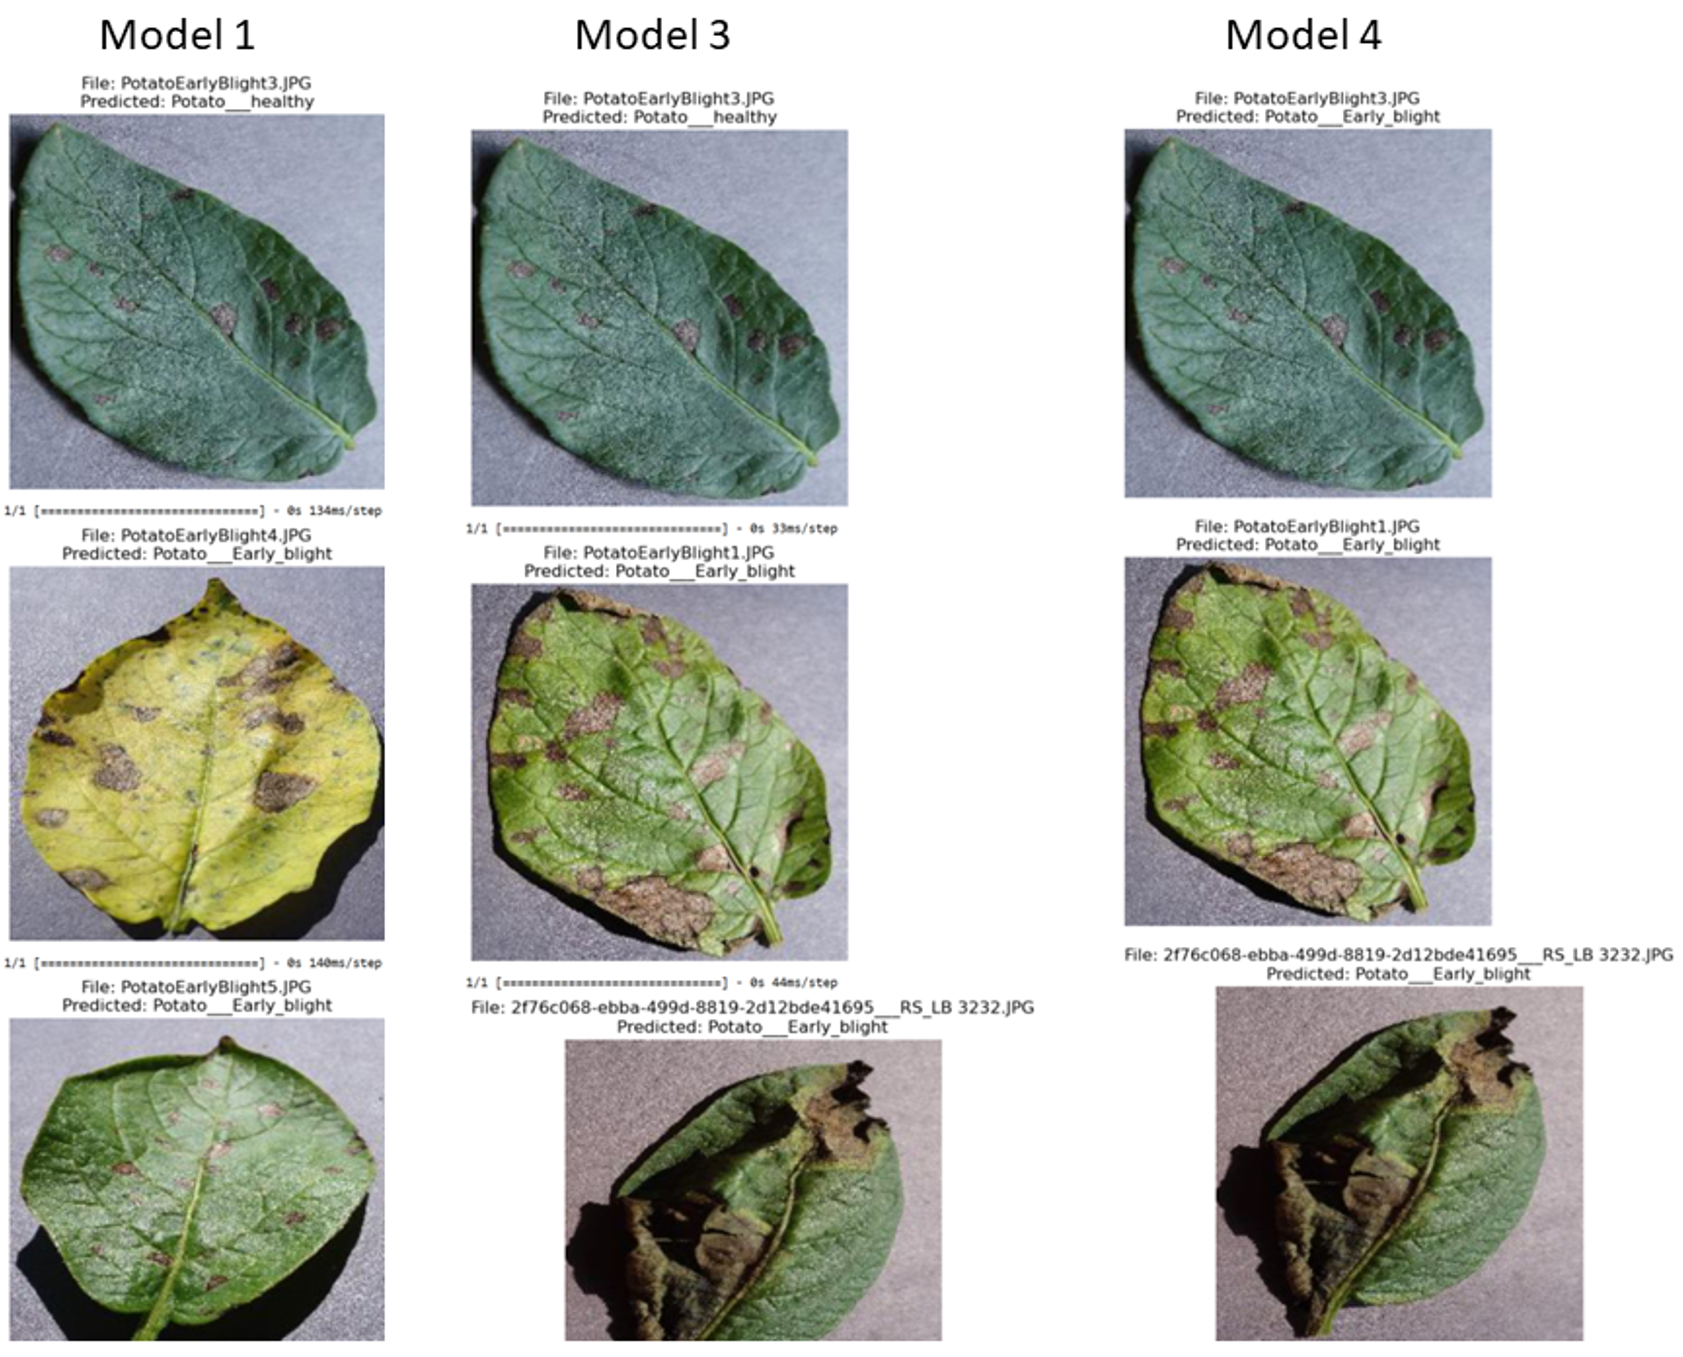

the 2 pictures without a clear file name correspond to late blight

1/1 [==============================] - 0s 38ms/step


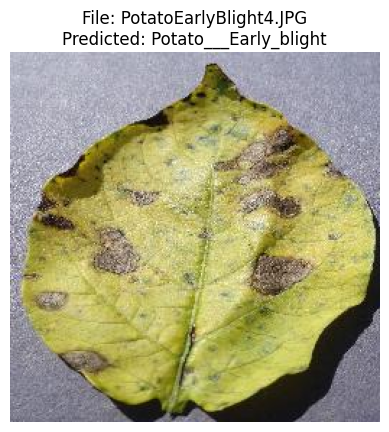

1/1 [==============================] - 0s 35ms/step


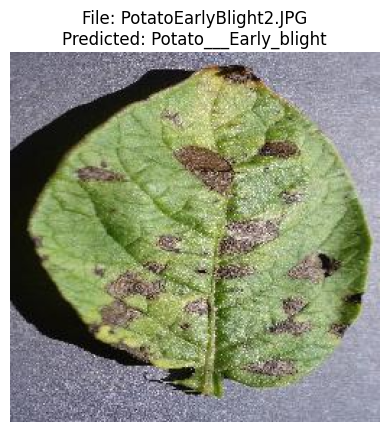

1/1 [==============================] - 0s 39ms/step


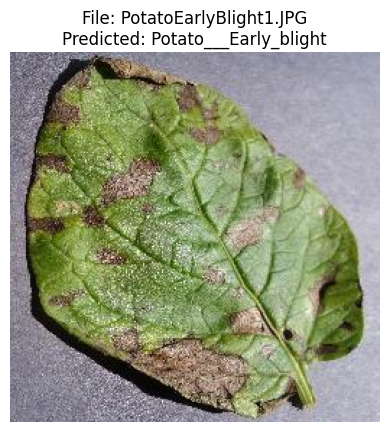

1/1 [==============================] - 0s 33ms/step


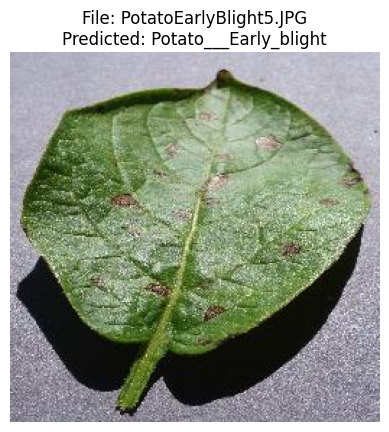

1/1 [==============================] - 0s 37ms/step


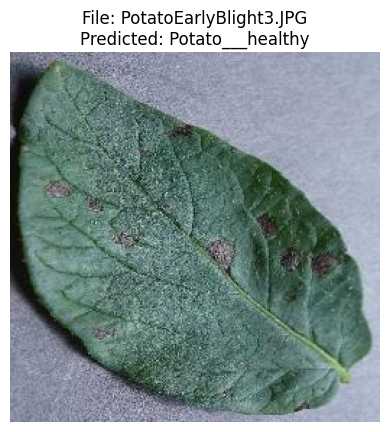

1/1 [==============================] - 0s 33ms/step


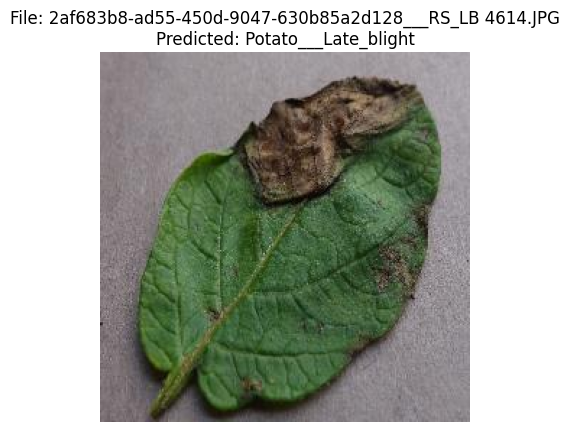

1/1 [==============================] - 0s 42ms/step


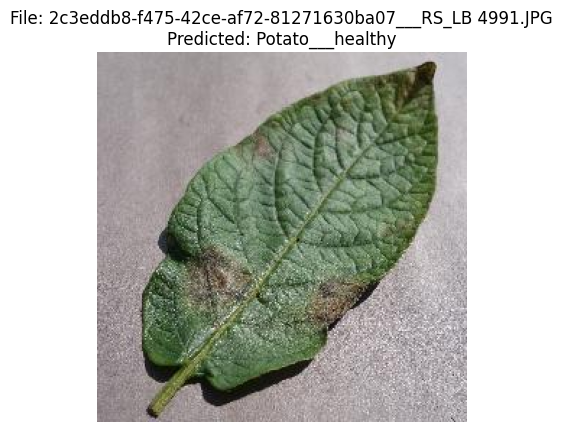

1/1 [==============================] - 0s 35ms/step


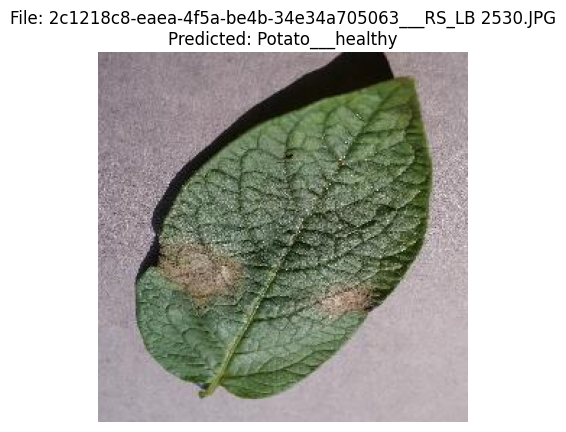

1/1 [==============================] - 0s 44ms/step


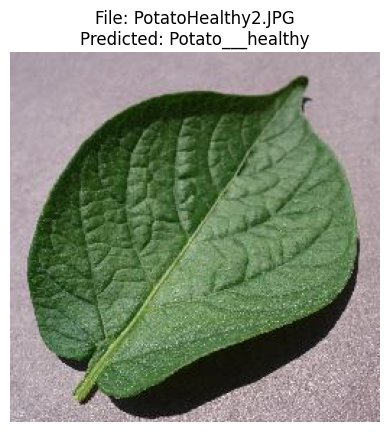

1/1 [==============================] - 0s 41ms/step


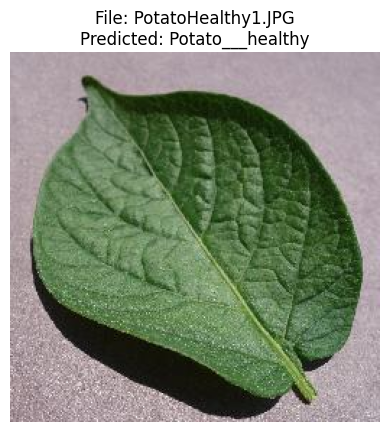

In [ ]:
from tensorflow.keras.preprocessing import image

class_names = sorted([item for item in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, item)) and item != '.DS_Store'])  # Updated this line

def load_and_preprocess_image(img_path, img_height, img_width):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_tensor = image.img_to_array(img)  # Convert the image to a numpy array
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Add a batch dimension
    img_tensor /= 255.  # Normalize to [0,1]
    return img_tensor

def display_prediction(img_path, predicted_label):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'File: {os.path.basename(img_path)}\nPredicted: {predicted_label}')
    plt.axis('off')
    plt.show()

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):  # Check if class_dir is a directory
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img_tensor = load_and_preprocess_image(img_path, img_height, img_width)
            predictions = model.predict(img_tensor)
            predicted_class = class_names[np.argmax(predictions[0])]
            display_prediction(img_path, predicted_class)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Found 10 images belonging to 3 classes.
10/10 [==============================] - 0s 13ms/step


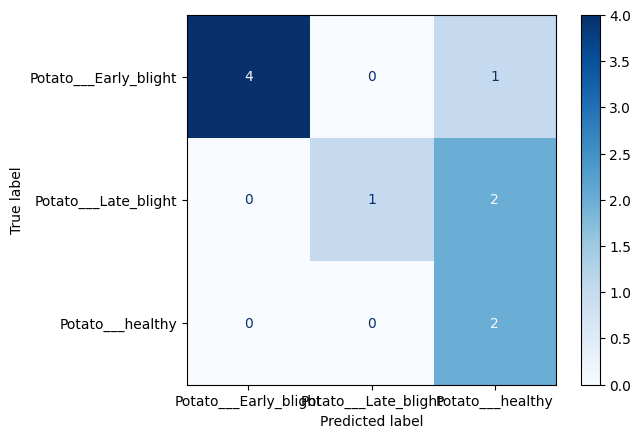

In [ ]:
# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/cropdisease/data/test',
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Get the true labels and model predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Recommendation**:

Based on the above analysis, Model 2 seems to be the most balanced choice for deployment as it has the highest number of correct predictions on the test set among Models 1, 2, and 3, and has good metrics across accuracy, precision, recall, and F1 score. It also has a decent balance between training and validation performance, which indicates a lesser degree of overfitting compared to Model 3.

However, the final decision might also depend on additional factors such as the deployment environment, computational resources, and the importance of model interpretability and maintainability.

**INSIGHTS**<br>
Creating a model like this takes a lot of computation resources. It is advisable to make it work in a more powerful computer or platform for further refining before deployment.<br>
This model seems to be the best performing out of the 4 based on metrics and te results with the test image set. It requires further testing with other pictures to verify accuracy.<br>
<br>
**NEXT STEPS**
<br>
The model could be first deployed as a web and Android app to make it more accesible for people around the world.<br>
We could use third party sets of potato leaves images around the world to further train it before its official release.<br>
The model should feed from the user's pictures for further improving accuracy. <br>
As a beta app it could be released only for certain farmers around the world so we can improve the model. <br>
Once the model is done we could charge a monthly subscription fee which can be reduced if they accept us using the data collected from the app for further research.<br>

In [ ]:
##END OF THE NOTEBOOK

**STUDENT NOTES** <br>
I grossly miscalculated the necessary computational power for training an iamge classification model.<br>
While local deployment wasn't that complicated, figuring out how to deploy a web app proved extremely complex.<br>
Also, in one attempt to develop a webapp, I spent around 5 hours just installing packages and setting up environments.<br>
This was a gratifying exercise in that I really tried to improve all of these models and in the process I became aware of many of my current limitations, the tediousness of the process, and how invested I can get while doing this. <br>